# Programming Assignment 4
Author: Alec M.

Date: 04/19/2022

Class: INST 447 (SP22)

## Goal
Use the Food Data Central API to pull the nutritional content of a typical Thanksgiving Meal

## Research Questions
1. Is there an association between the amount of protein and energy in a food?
2. Which food is the most nutritious?
3. Which food is the least nutritious?

## Workspace Preparation

In [26]:
# Import modules
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize

# Configure Plot Defaults
%matplotlib inline
sns.set(rc={'figure.figsize':(18, 8)})

In [2]:
# Define USDA API Key
apiKey = "Bq9wAKJOhGuIHG1Z7y0gSwRAZYsOLQVY9lZHPtv9"

# Fetch API Data

In [3]:
# List of food we want info on
food_list = [
  "turkey",
  "macaroni and cheese",
  "mashed potatoes",
  "bread stuffing",
  "ham",
  "sweet potato souffle",
  "cranberry sauce",
  "mixed vegetables",
  "apple pie",
  "pecan pie"
]

In [9]:
# Track current food
counter = 0

# Loop through food requests
for food in food_list:
  counter = counter + 1
  response = requests.post(r'https://api.nal.usda.gov/fdc/v1/search',
    params = {'api_key': apiKey},
    json = {'generalSearchInput': food}
  )
  item = response.json()
  l = [i for i in range(len(item['foods']))]
  
  # for each match
  for i in l:
      if i == 0:
          rdf = pd.json_normalize(item['foods'][i]['foodNutrients'])
      else:
          df = pd.json_normalize(item['foods'][i]['foodNutrients'])
          rdf = pd.concat([rdf,df])
  
  # Rename DF columns names
  rdf['nutrientName'].replace('Energy', 'Energy', inplace = True)
  rdf['nutrientName'].replace('Carbohydrate, by difference', 'Carbs', inplace = True)
  rdf['nutrientName'].replace('Protein', 'Protein', inplace = True)
  rdf['nutrientName'].replace('Fiber, total dietary', 'Fiber', inplace = True)
  rdf['nutrientName'].replace('Total lipid (fat)', 'Fat', inplace = True)
  agg_food = rdf[['nutrientName','value']].groupby(['nutrientName']).agg('mean')
  agg_food = agg_food.reset_index()
  agg_food.columns = ["nutrientName","Value"]    
  
  # Subset the fields we need
  agg_food = agg_food[agg_food["nutrientName"].isin(['Energy','Carbs','Protein','Fiber','Fat'])]
  agg_food["Food"] = food 
      
  # Transpose the DF
  new = agg_food.pivot_table(index = ["Food"], columns = ['nutrientName'], values = 'Value')
  new.reset_index(inplace=True)
  
  # Append DF to all foods DF
  if counter == 1:
      all_foods = new
  else:
      all_foods = pd.concat([all_foods, new]) 

In [10]:
# Print DF
all_foods

nutrientName,Food,Carbs,Energy,Fat,Fiber,Protein
0,turkey,6.722600,431.455882,12.502400,0.329787,16.2948
0,macaroni and cheese,20.468400,329.632353,6.891600,0.946000,6.6384
0,mashed potatoes,42.527400,236.351852,3.848400,3.226000,4.7308
0,bread stuffing,27.500600,361.431034,10.006200,2.278000,8.2718
0,ham,8.734600,292.492063,8.775800,0.492683,13.6342
0,sweet potato souffle,25.800000,232.466667,7.047800,2.688000,2.9092
0,cranberry sauce,27.093469,217.928571,0.620000,1.885417,1.8286
0,mixed vegetables,9.611000,49.204082,0.022653,2.148000,1.7202
0,apple pie,37.518000,321.240741,12.848200,2.202041,2.8270
0,pecan pie,43.640000,502.185185,23.939200,2.665306,4.5754


# Analysis



## Question 1 
Is there an association between the amount of protein and energy in a food?

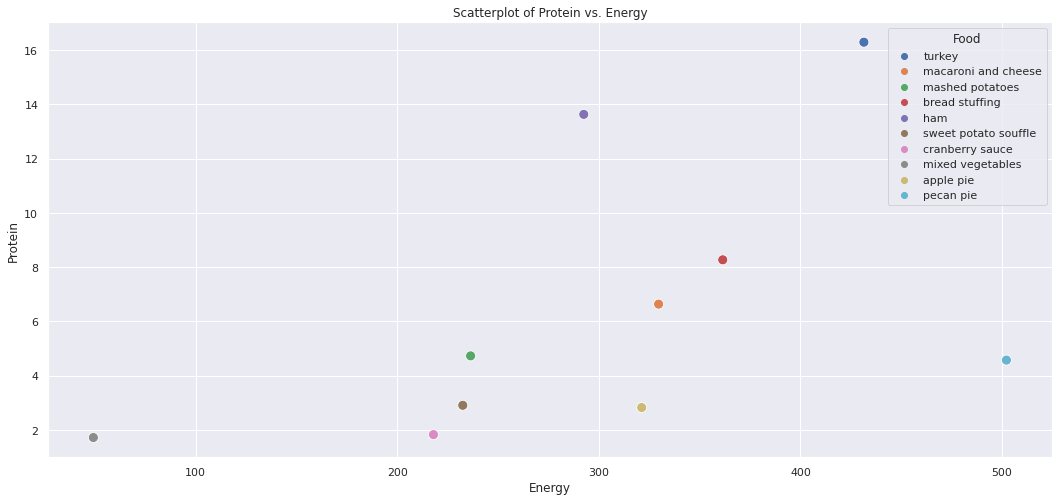

In [28]:
# Create Plot
sns.scatterplot(y = 'Protein', x = 'Energy', hue = 'Food', s = 100, data = all_foods, legend = "auto")

# Add Labels
plt.title("Scatterplot of Protein vs. Energy")
plt.xlabel("Energy")
plt.ylabel("Protein")

# Hide Output
None;

From the above scatterplot, we can determine that there does appear to be some relationship between the amount of protein in foods and their concentration of energy. However, this relationship does not necessarily appear to be perfectly linear, as seen by the out of line data points (Turkey, Cranberry Sauce, etc).

## Question 2
Nutrient concentration across each food type.

### Carbohydrates (Carbs)

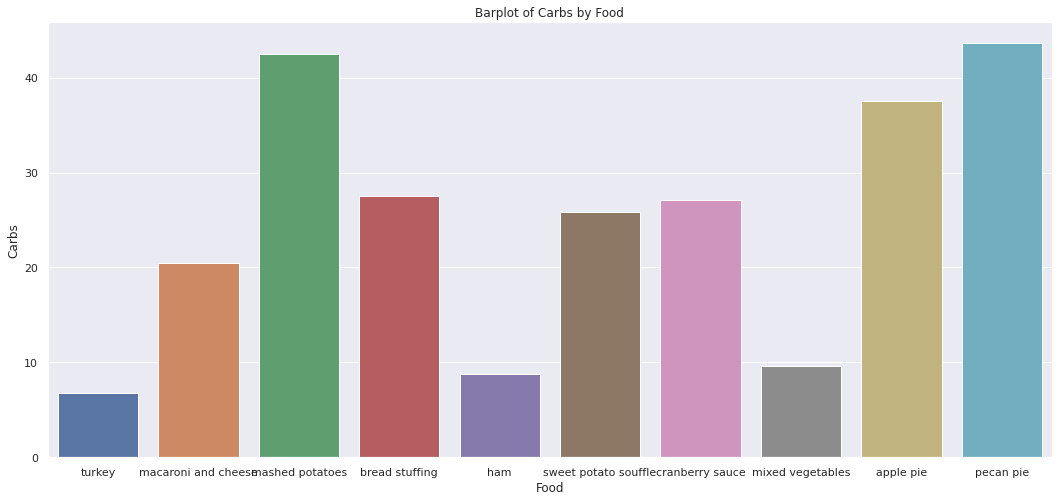

In [30]:
# Create Plot
sns.barplot(y = 'Carbs', x = 'Food', data = all_foods)

# Add Labels
plt.title("Barplot of Carbs by Food")
plt.ylabel("Carbs")
plt.xlabel("Food")

# Hide Output
None;

The above bar plot provides significant insight into the carb  breakdown by food type. We can see that mashed potatoes and pecan pie have almost equally high number of carbs per serving. Additionally, turkey or ham are the lowest carb options available in this food list.

### Energy

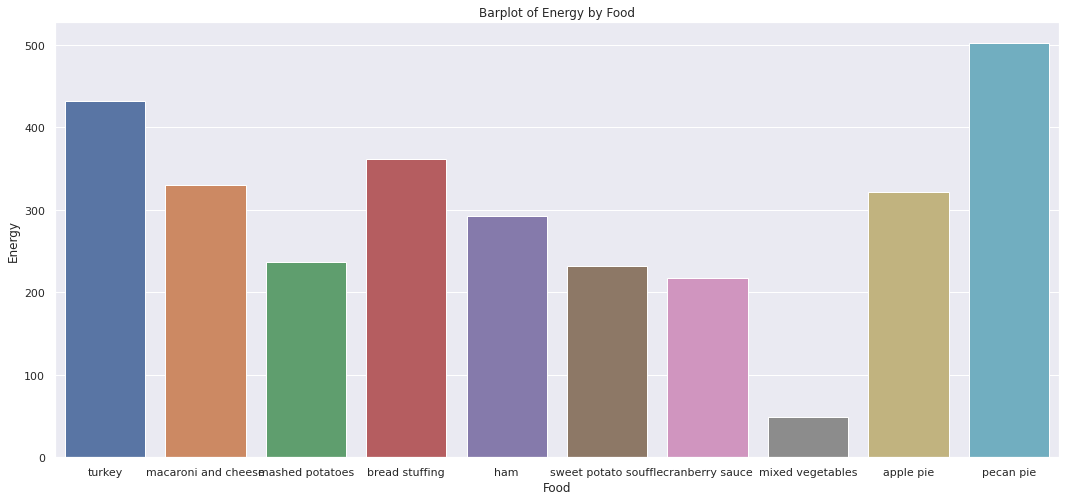

In [31]:
# Create Plot
sns.barplot(y = 'Energy', x = 'Food', data = all_foods)

# Add Labels
plt.title("Barplot of Energy by Food")
plt.ylabel("Energy")
plt.xlabel("Food")

# Hide Output
None;

Unlike the previous graph, this graph of energy vs. food type demonstrates that there are quite a few types of food that offer high energy amounts. Interestingly, mixed vegegtables seem to offer the lowest amount of energy per serving. On the other hand, Pecan pie offers the most energy per serving, likely because of the sugar contents. 

### Fat

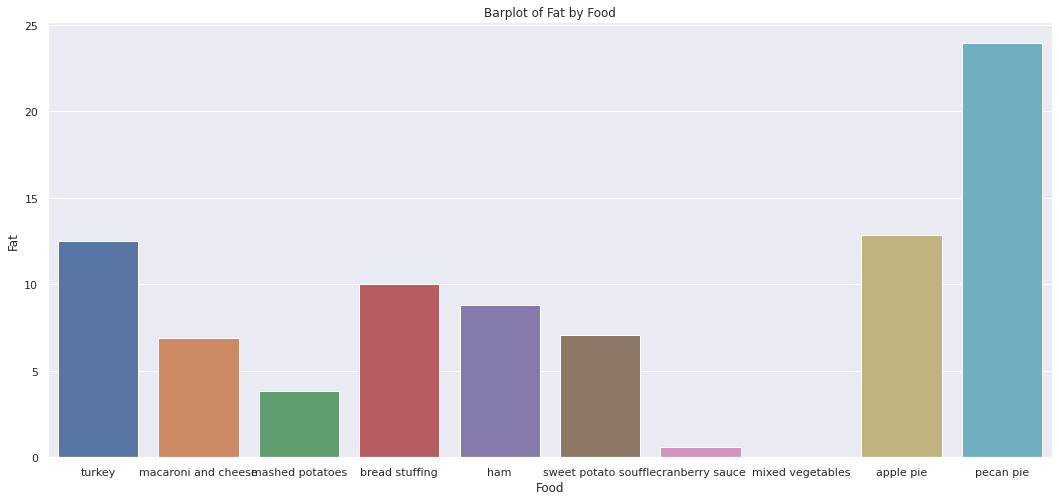

In [35]:
# Create Plot
sns.barplot(y = 'Fat', x = 'Food', data = all_foods)

# Add Labels
plt.title("Barplot of Fat by Food")
plt.ylabel("Fat")
plt.xlabel("Food")

# Hide Output
None;

The above graph provides very useful information for those who want to limit their fat intake during the holidays. We can see that both types of pie have extremely high fat contents per serving. While, mashed potatoes, macaroni and cheese, and cranberry sauce offer the least per serving.

### Fiber

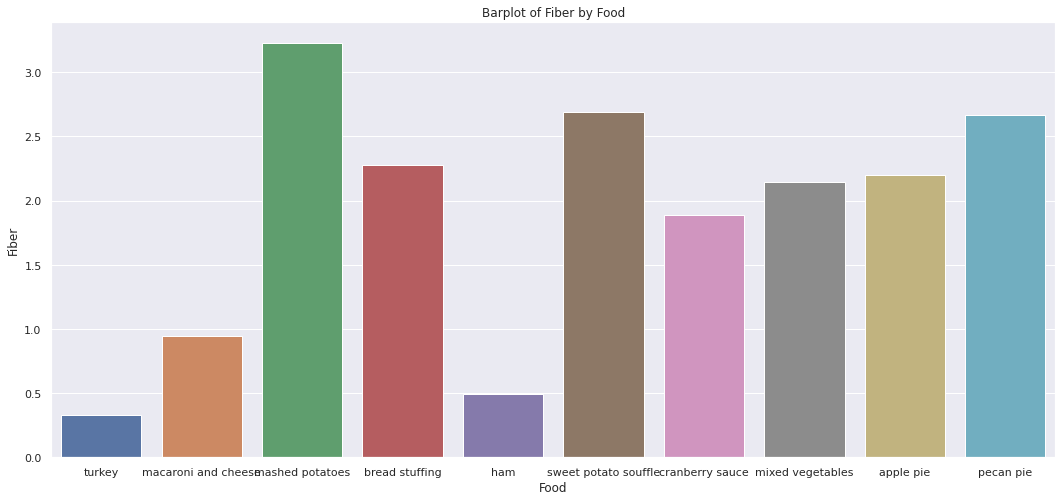

In [33]:
# Create Plot
sns.barplot(y = 'Fiber', x = 'Food', data = all_foods)

# Add Labels
plt.title("Barplot of Fiber by Food")
plt.ylabel("Fiber")
plt.xlabel("Food")

# Hide Output
None;

The above graph outlines the fiber contents per food type. The two foods with the lowest fiber are Turkey and Ham, which is expected. For the highest amount of fiber, someone will want to consume mashed potatoes or sweet potato souffle. One interesting observation is that a majority of the foods do contain nearly equal amounts of fiber, although the reasoning for this is unknown.

### Protein

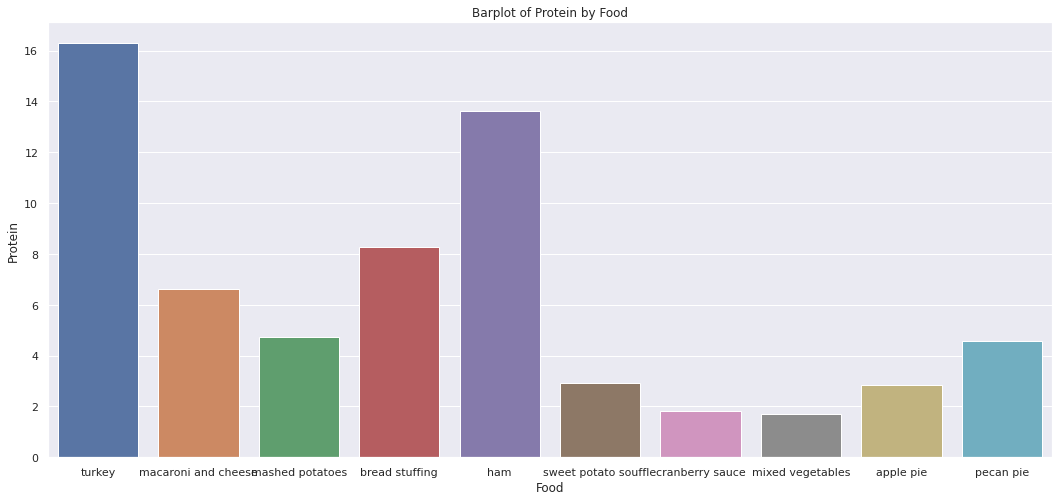

In [34]:
# Create Plot
sns.barplot(y = 'Protein', x = 'Food', data = all_foods)

# Add Labels
plt.title("Barplot of Protein by Food")
plt.ylabel("Protein")
plt.xlabel("Food")

# Hide Output
None;

The above bar plot outlines the protein contents of each food in our dataset. Contrary to the Fiber contents, the most protein comes from Turkey and Ham, and the least comes from cranberry sauce or mixed vegetables. Again, similar to Fiber, the remaining food types seem to maintain similar protein contents.

# Summary

## Question 1
**Based on the graphs above, which of the Thanksgiving foods would you say is the healthiest/most nutritious, and why? There is no wrong answer here.**

As we discovered with the above five graphs, there's quite a big variance between each food type in their nutrient contents. I believe this answer changes depending on each individual's objectives or end goals. With that being said, I would pick the Protein-based graph to make a decision. Pulled from the protein graph, we can see that Turkey would be the most suitable food choice of the 10 options available. Although I'm not a nutritionist, I feel that protein might be the most valuable nutriet to have.

## Question 2
**Based on the graphs above, which of the Thanksgiving foods would you say is the least healthiest/least nutritious, and why? There is no wrong answer here.**

Similar to Question 1, this answer heavily depends on the end objective of the person eating the food. But I think that, based on it's rankings across all of the graphs, Cranberry sauce would be the least healthiest. This answer is probably somewhat obvious, especially given that it inherently can't contain too many valuable nutrients. Second to that, any of the pies are likely not too beneficial to consume. One thing to consider is the sugar contents of these foods was not included, and I suspect that all three of the aforementioned foods (Both pies, cranberry sauce) likely have extremely high sugar contents.